# Capstone Project Week 2- Battle of the Neighborhoods

### Importing Libraries

In [47]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [49]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [50]:
#!conda install -c conda-forge seaborn --yes
import seaborn as sns

### Collecting and wrangling New York Data

In [51]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [52]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [53]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Getting New York City Co-ordinates and plotting the neighborhoods on the map

In [54]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [55]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Getting Brooklyn Data and plotting on the map

In [56]:
BRneighborhoods = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
BRneighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [57]:
# create map of New York using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(BRneighborhoods['Latitude'], BRneighborhoods['Longitude'], BRneighborhoods['Borough'], BRneighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

### Storing Foursquare API credentials

In [58]:
CLIENT_ID = 'XFKLLHHR0KDWYHQ02QMLOKFVUBF2UDDANUA1JIHDMENMPQLS' # your Foursquare ID
CLIENT_SECRET = 'U4CAR1RBF5MWG3ZAY2KCGWOEOIAVPLSSJ3ERV5F53XGOC1TM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
radius = 500

Your credentails:
CLIENT_ID: XFKLLHHR0KDWYHQ02QMLOKFVUBF2UDDANUA1JIHDMENMPQLS
CLIENT_SECRET:U4CAR1RBF5MWG3ZAY2KCGWOEOIAVPLSSJ3ERV5F53XGOC1TM


### Getting venues of the neighborhoods of Brooklyn

In [59]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [60]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [61]:
BYN_venues = getNearbyVenues(names=BRneighborhoods['Neighborhood'],
                                   latitudes=BRneighborhoods['Latitude'],
                                   longitudes=BRneighborhoods['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [62]:
print(BYN_venues.shape)
BYN_venues.head()

(2740, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,The Bookmark Shoppe,40.624577,-74.030562,Bookstore


In [63]:
print('Number of unique categories is:', len(BYN_venues['Venue Category'].unique()))
print('Number of unique venues is:', len(BYN_venues['Venue'].unique()))

Number of unique categories is: 288
Number of unique venues is: 2227


### Visualizing the Venue categories and number of venues across neighborhoods of Brooklyn

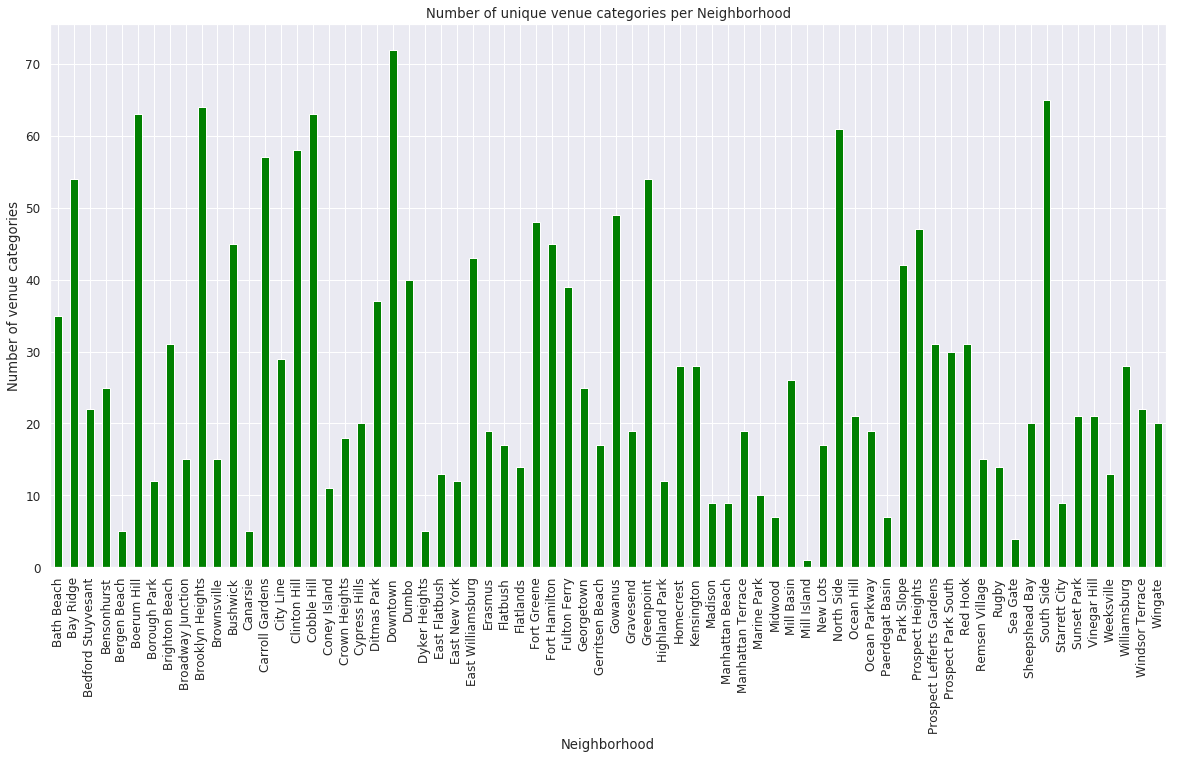

In [64]:
categories = BYN_venues.groupby("Neighborhood")["Venue Category"].apply(lambda x: len(list(np.unique(x))))
categories.plot(kind='bar', 
             stacked=False,
             figsize=(20, 10),color="Green")
plt.title('Number of unique venue categories per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of venue categories')
plt.show()


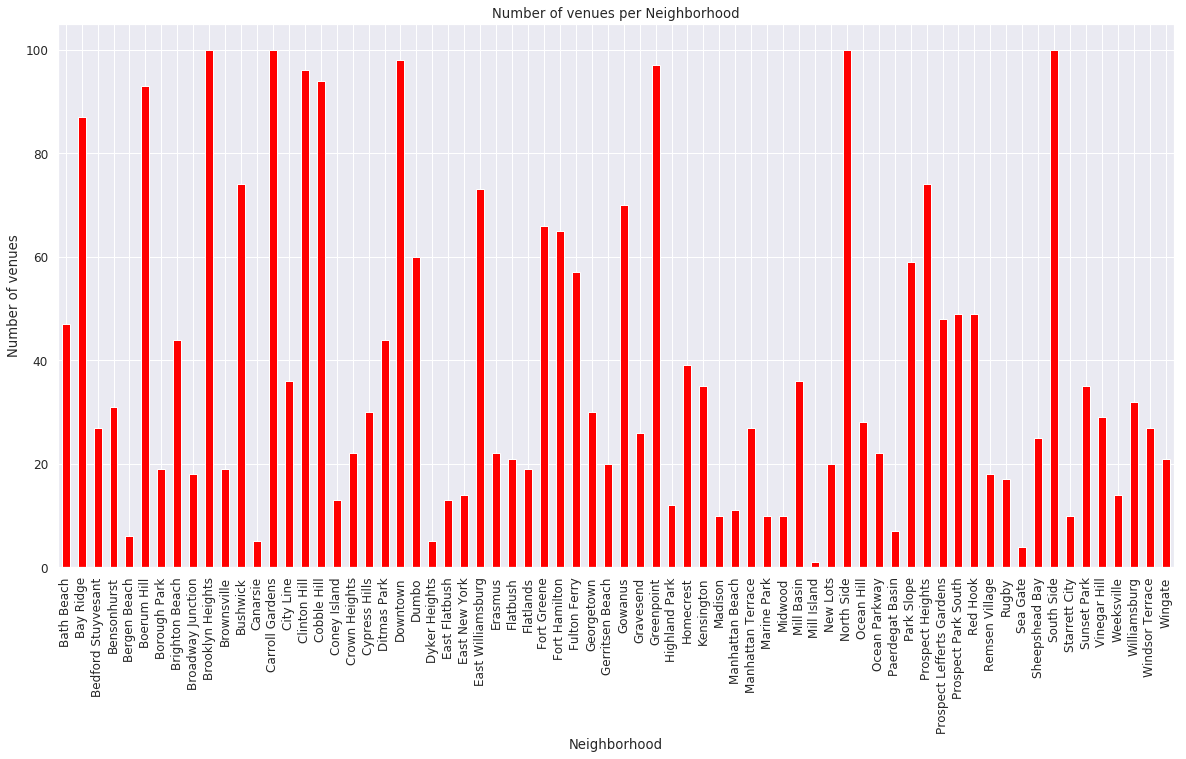

In [65]:
categories = BYN_venues.groupby("Neighborhood")["Venue"].count()
categories.plot(kind='bar', 
             stacked=False,
             figsize=(20, 10),color="Red")
plt.title('Number of venues per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of venues')
plt.show()

### Getting a count of venue categories across the neighborhoods of Brooklyn

In [66]:
VenueCatCount = BYN_venues.groupby("Venue Category")["Neighborhood"].count().to_frame()
VenueCatCount.columns = ["Frequency"]
VenueCatCount = VenueCatCount.reset_index()
VenueCatCount.sort_values(by='Frequency', ascending=False, inplace=True)
VenueCatCount.head(15)

,Venue Category,Frequency
207,Pizza Place,137
64,Coffee Shop,95
19,Bar,83
150,Italian Restaurant,65
74,Deli / Bodega,64
17,Bakery,64
126,Grocery Store,57
58,Chinese Restaurant,53
172,Mexican Restaurant,49
202,Pharmacy,48


### Creating a new Dataframe that contains TOP 10 Venues of the neighborhood

In [67]:
# one hot encoding
BYN_onehot = pd.get_dummies(BYN_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BYN_onehot['Neighborhood'] = BYN_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [BYN_onehot.columns[-1]] + list(BYN_onehot.columns[:-1])
BYN_onehot = BYN_onehot[fixed_columns]

BYN_onehot.head()

,Yoga Studio,Accessories Store,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
BYN_onehot.shape

(2740, 288)

In [69]:
BYN_grouped = BYN_onehot.groupby('Neighborhood').mean().reset_index()
BYN_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bath Beach,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bay Ridge,0.000000,0.000000,0.000000,0.034483,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.011494,0.000000,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bedford Stuyvesant,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000
3,Bensonhurst,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bergen Beach,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Boerum Hill,0.021505,0.000000,0.000000,0.010753,0.00,0.010753,0.00,0.000000,0.010753,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753,0.000000,0.000000
6,Borough Park,0.000000,0.000000,0.000000,0.052632,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Brighton Beach,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Broadway Junction,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Brooklyn Heights,0.040000,0.000000,0.000000,0.020000,0.00,0.000000,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.020000,0.000000,0.010000


In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BYN_grouped['Neighborhood']

for ind in np.arange(BYN_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BYN_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Pizza Place,Pharmacy,Italian Restaurant,Bubble Tea Shop,Fast Food Restaurant,Gas Station,Park,Cantonese Restaurant,Surf Spot
1,Bay Ridge,Spa,Italian Restaurant,Greek Restaurant,Pizza Place,Pharmacy,American Restaurant,Chinese Restaurant,Bar,Bagel Shop,Mediterranean Restaurant
2,Bedford Stuyvesant,Pizza Place,Coffee Shop,Bar,Café,Deli / Bodega,Park,Discount Store,Cocktail Bar,New American Restaurant,Tiki Bar
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Donut Shop,Ice Cream Shop,Liquor Store,Russian Restaurant,Cha Chaan Teng,Noodle House,Sporting Goods Shop
4,Bergen Beach,Harbor / Marina,Playground,Donut Shop,Athletics & Sports,Baseball Field,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant
5,Boerum Hill,Dance Studio,Coffee Shop,Bar,French Restaurant,Furniture / Home Store,Bakery,Sandwich Place,Arts & Crafts Store,Gym / Fitness Center,Spa
6,Borough Park,Bank,Pizza Place,Pharmacy,Fast Food Restaurant,Hotel,Grocery Store,Coffee Shop,Restaurant,Chinese Restaurant,Café
7,Brighton Beach,Russian Restaurant,Restaurant,Beach,Eastern European Restaurant,Mobile Phone Shop,Sushi Restaurant,Gourmet Shop,Bank,Fried Chicken Joint,Supermarket
8,Broadway Junction,Fried Chicken Joint,Donut Shop,Diner,Hotel,Discount Store,Caribbean Restaurant,Sandwich Place,Nightclub,Bus Stop,Bus Station
9,Brooklyn Heights,Deli / Bodega,Yoga Studio,Pizza Place,Park,Bakery,Gym,Italian Restaurant,Mexican Restaurant,Pet Store,Juice Bar


### Visualizing the frequency distribution of our desired venues thet needs to be present across all neighborhoods of Brooklyn

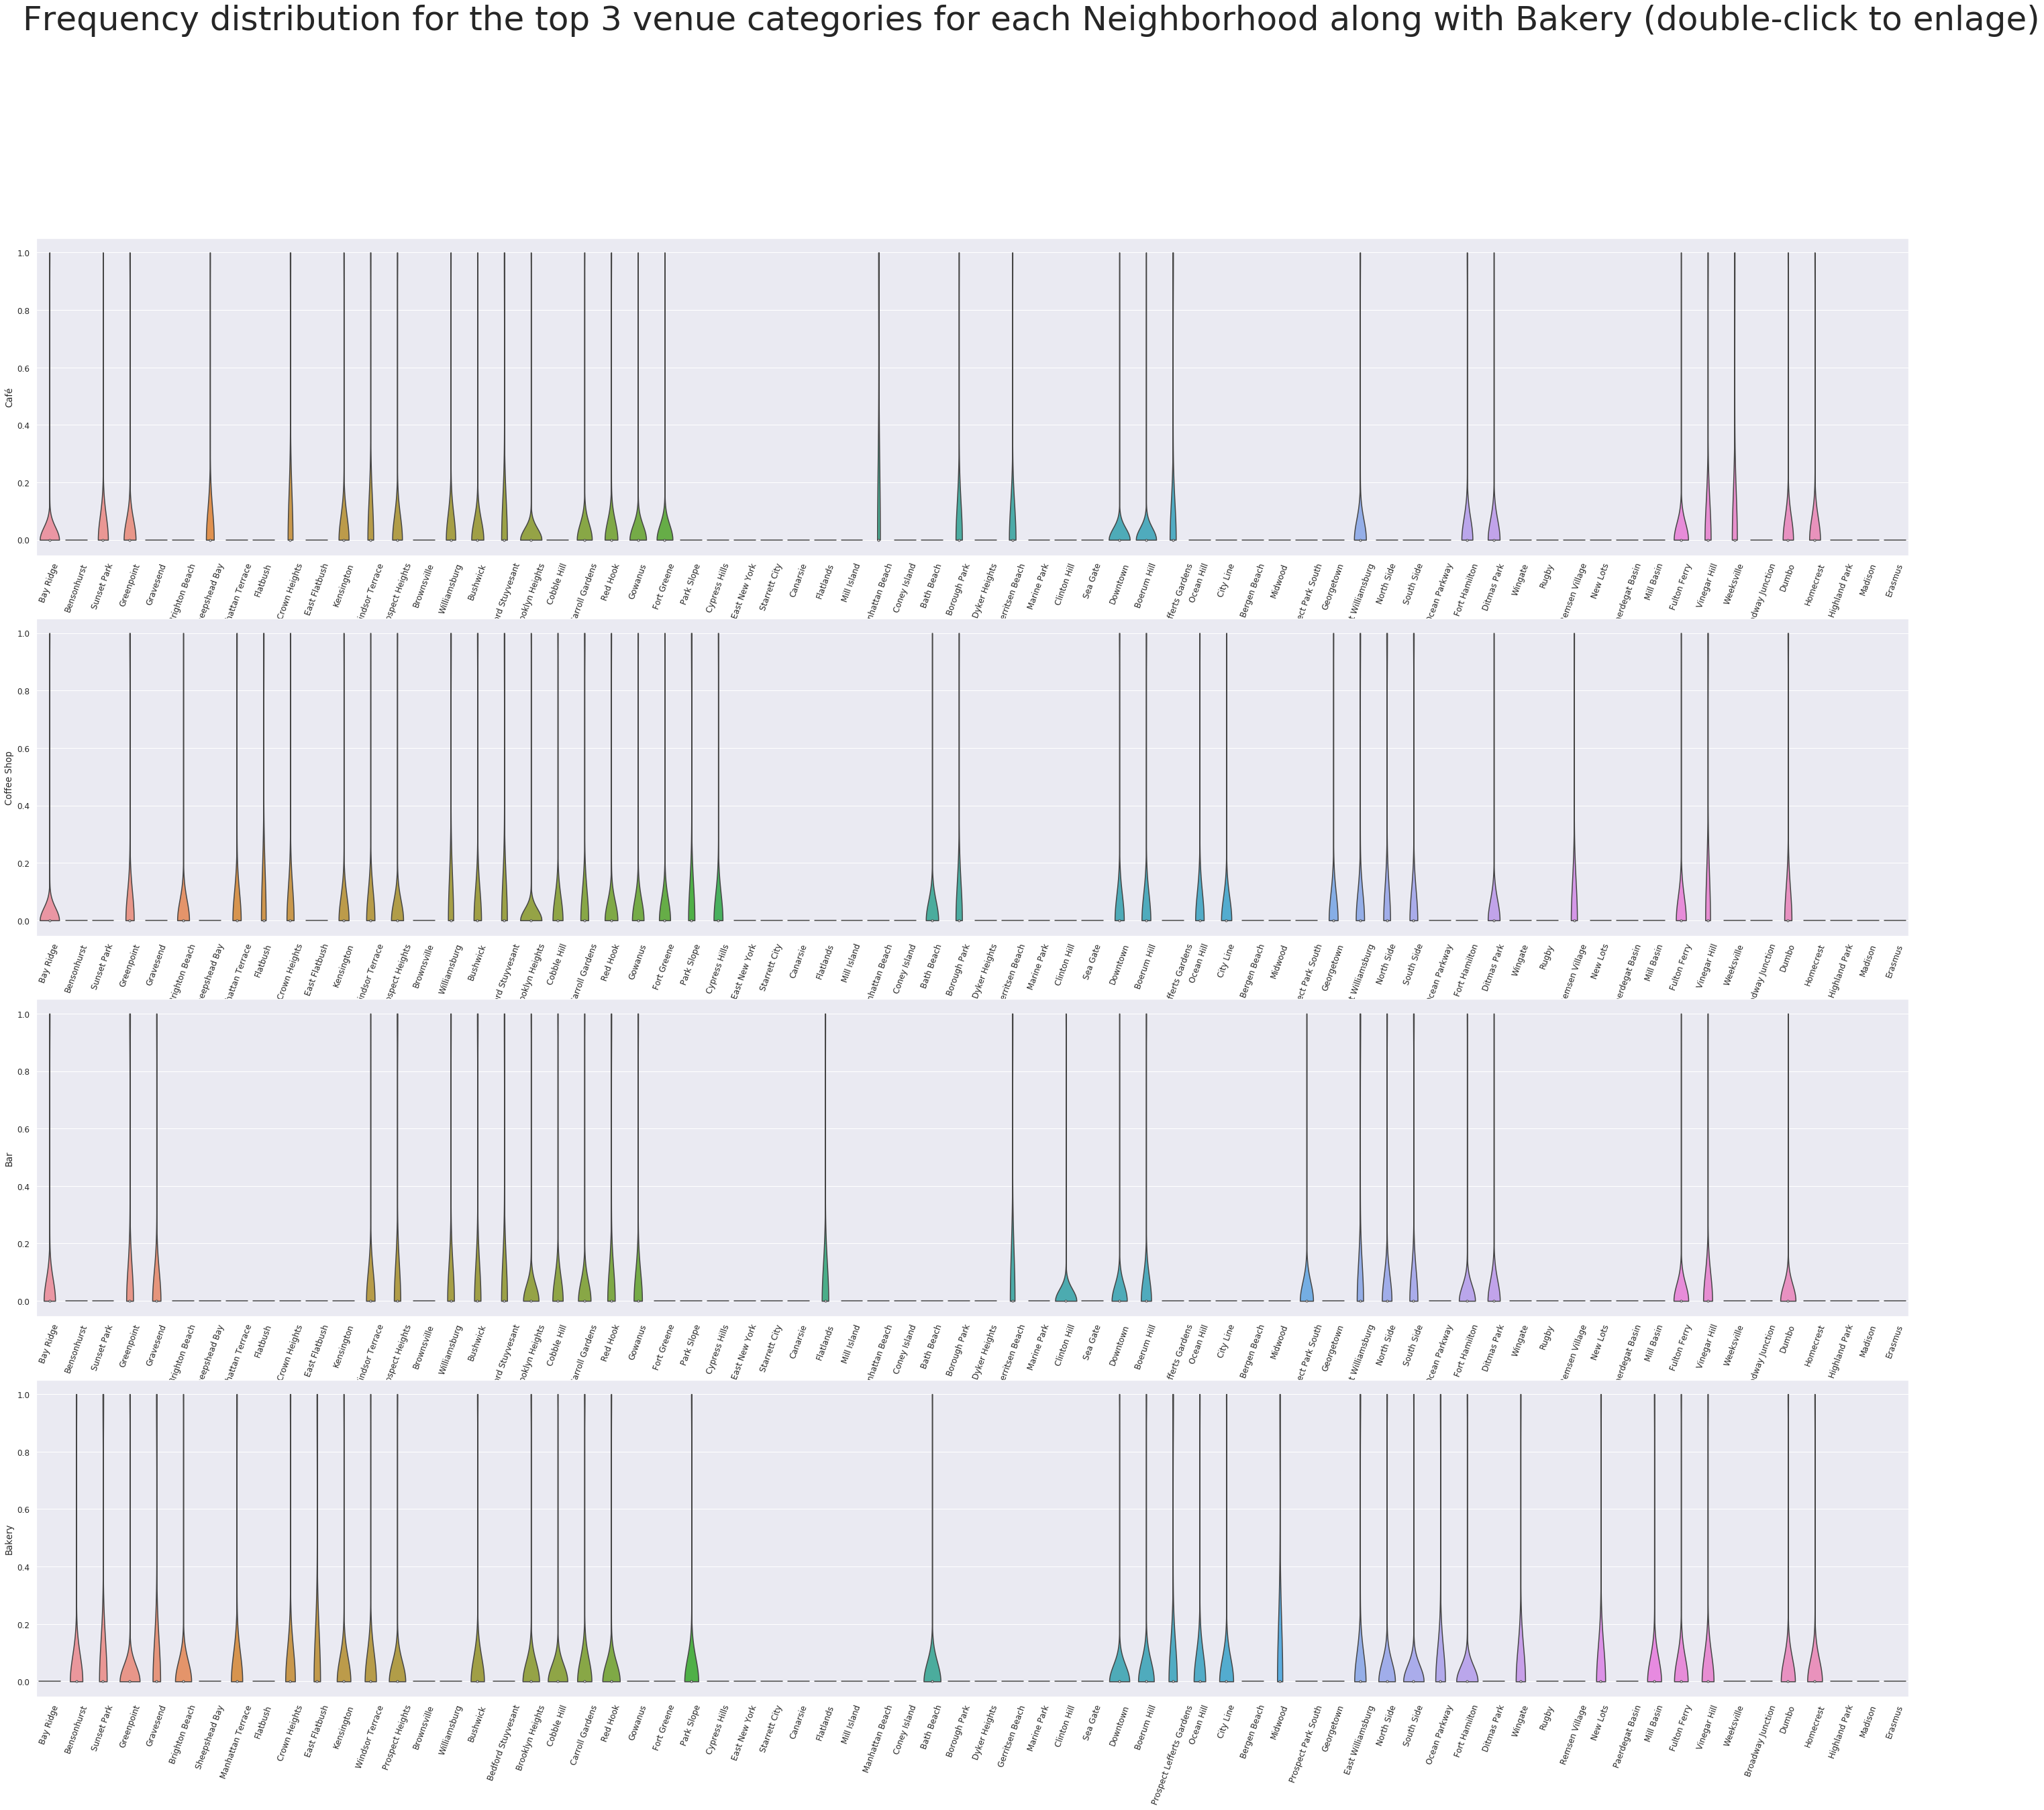

In [72]:
fig = plt.figure(figsize=(50,40))
sns.set(font_scale=1.1)

ax = plt.subplot(4,1,1)
sns.violinplot(x="Neighborhood", y="Café", data=BYN_onehot, cut=0);
plt.xlabel("")
plt.xticks(rotation=70)

ax = plt.subplot(4,1,2)
sns.violinplot(x="Neighborhood", y="Coffee Shop", data=BYN_onehot, cut=0);
plt.xlabel("")
plt.xticks(rotation=70)

plt.subplot(4,1,3)
sns.violinplot(x="Neighborhood", y="Bar", data=BYN_onehot, cut=0);
plt.xlabel("")
plt.xticks(rotation=70)

plt.subplot(4,1,4)
sns.violinplot(x="Neighborhood", y="Bakery", data=BYN_onehot, cut=0);
plt.xlabel("")
plt.xticks(rotation=70)

ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each Neighborhood along with Bakery (double-click to enlage)', fontsize=50)
plt.savefig ("Distribution_Frequency_Venues_3_categories.png", dpi=240)
plt.show()

### Based on this frequency distribution we will select top 3 neighborhoods that could be the potential location for us and visualizing them on map

#### As we want those locations which have more Cafe, Bars and coffee shop but less Bakery

In [73]:
Potential_nbhd = neighborhoods[neighborhoods["Neighborhood"].isin(['Ditmas Park',
                                         'Gowanus',
                                         'Bay Ridge'])]
Potential_nbhd

,Borough,Neighborhood,Latitude,Longitude
46,Brooklyn,Bay Ridge,40.625801,-74.030621
68,Brooklyn,Gowanus,40.673931,-73.994441
221,Brooklyn,Ditmas Park,40.643675,-73.961013


In [74]:
# Create a map of Brooklyn with the 3 selected streets
map_Potential_nbhd = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(Potential_nbhd['Latitude'], Potential_nbhd['Longitude'],
                           Potential_nbhd['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=45,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_Potential_nbhd)  
    
map_Potential_nbhd

### Clustering the Neighborhoods based on the desired venue location

In [75]:
Café_nbrh = BYN_grouped[['Neighborhood', 'Café']]
Café_nbrh_Agg = Café_nbrh.groupby('Neighborhood').sum().reset_index()
Café_nbrh_Agg.head()

,Neighborhood,Café
0,Bath Beach,0.000000
1,Bay Ridge,0.011494
2,Bedford Stuyvesant,0.074074
3,Bensonhurst,0.000000
4,Bergen Beach,0.000000


In [76]:
Bar_nbrh = BYN_grouped[['Neighborhood', 'Bar']]
Bar_nbrh_Agg = Bar_nbrh.groupby('Neighborhood').sum().reset_index()
Bar_nbrh_Agg.head()

,Neighborhood,Bar
0,Bath Beach,0.000000
1,Bay Ridge,0.034483
2,Bedford Stuyvesant,0.074074
3,Bensonhurst,0.000000
4,Bergen Beach,0.000000


In [77]:
Bakery_nbrh = BYN_grouped[['Neighborhood', 'Bakery']]
Bakery_nbrh_Agg = Bakery_nbrh.groupby('Neighborhood').sum().reset_index()
Bakery_nbrh_Agg.head()

,Neighborhood,Bakery
0,Bath Beach,0.021277
1,Bay Ridge,0.000000
2,Bedford Stuyvesant,0.000000
3,Bensonhurst,0.032258
4,Bergen Beach,0.000000


In [78]:
Coffee_nbrh = BYN_grouped[['Neighborhood', 'Coffee Shop']]
Coffee_nbrh_Agg = Coffee_nbrh.groupby('Neighborhood').sum().reset_index()
Coffee_nbrh_Agg.head()

,Neighborhood,Coffee Shop
0,Bath Beach,0.021277
1,Bay Ridge,0.011494
2,Bedford Stuyvesant,0.074074
3,Bensonhurst,0.000000
4,Bergen Beach,0.000000


In [79]:
Café_Bar =  pd.merge(Café_nbrh_Agg, Bar_nbrh_Agg, on="Neighborhood") 
Coffee_Bakery = pd.merge(Coffee_nbrh_Agg, Bakery_nbrh_Agg, on="Neighborhood")
df_agg = pd.merge(Café_Bar, Coffee_Bakery, on="Neighborhood")
df_agg.columns = ['Neighborhood', 'Nearby Café', 'Nearby Bar', 'Nearby Coffee Shop', 'Nearby Bakery']

In [80]:
df_agg = pd.merge(neighborhoods, df_agg, on="Neighborhood")
df_agg.head()

,Borough,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0.011494,0.034483,0.011494,0.000000
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0.000000,0.000000,0.000000,0.032258
2,Brooklyn,Sunset Park,40.645103,-74.010316,0.028571,0.000000,0.000000,0.085714
3,Brooklyn,Greenpoint,40.730201,-73.954241,0.030928,0.092784,0.061856,0.020619
4,Brooklyn,Gravesend,40.595260,-73.973471,0.000000,0.038462,0.000000,0.076923


In [81]:
Neigh_clust = df_agg.drop(['Borough','Neighborhood'], axis=1)
df_agg.head()


,Borough,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0.011494,0.034483,0.011494,0.000000
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0.000000,0.000000,0.000000,0.032258
2,Brooklyn,Sunset Park,40.645103,-74.010316,0.028571,0.000000,0.000000,0.085714
3,Brooklyn,Greenpoint,40.730201,-73.954241,0.030928,0.092784,0.061856,0.020619
4,Brooklyn,Gravesend,40.595260,-73.973471,0.000000,0.038462,0.000000,0.076923


In [82]:
df_agg=df_agg.drop(['Borough'], axis=1)
df_agg.head()

,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery
0,Bay Ridge,40.625801,-74.030621,0.011494,0.034483,0.011494,0.000000
1,Bensonhurst,40.611009,-73.995180,0.000000,0.000000,0.000000,0.032258
2,Sunset Park,40.645103,-74.010316,0.028571,0.000000,0.000000,0.085714
3,Greenpoint,40.730201,-73.954241,0.030928,0.092784,0.061856,0.020619
4,Gravesend,40.595260,-73.973471,0.000000,0.038462,0.000000,0.076923


### Finding the optimum number of clusters using the elbow method

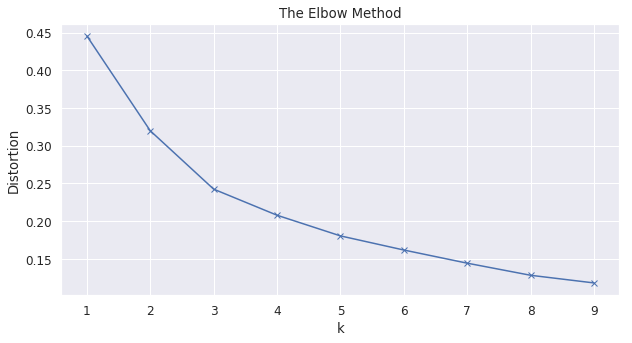

In [83]:
distortions = []

K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(Neigh_clust)
    distortions.append(kmean.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

### From here we can see that 3 clusters are optimum for this data

### Now we are segmenting the neighborhoods into these clusters

In [84]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_agg['Neighborhood'].astype(str))
df_agg['Neighborhood'] = le.transform(df_agg['Neighborhood'].astype(str))
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_agg)
df_agg['Cluster Labels'] = kmeans.labels_
df_agg.head()

,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery,Cluster Labels
0,1,40.625801,-74.030621,0.011494,0.034483,0.011494,0.000000,1
1,3,40.611009,-73.995180,0.000000,0.000000,0.000000,0.032258,1
2,64,40.645103,-74.010316,0.028571,0.000000,0.000000,0.085714,2
3,37,40.730201,-73.954241,0.030928,0.092784,0.061856,0.020619,0
4,36,40.595260,-73.973471,0.000000,0.038462,0.000000,0.076923,0


### Visualizing the clusters created

In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_agg['Latitude'], df_agg['Longitude'], df_agg['Neighborhood'], df_agg['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [86]:
df_Cluster1=df_agg[df_agg['Cluster Labels'] == 0]
df_Cluster1

,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery,Cluster Labels
3,37,40.730201,-73.954241,0.030928,0.092784,0.061856,0.020619,0
4,36,40.595260,-73.973471,0.000000,0.038462,0.000000,0.076923,0
7,43,40.614433,-73.957438,0.000000,0.000000,0.037037,0.037037,0
8,28,40.636326,-73.958401,0.000000,0.000000,0.095238,0.000000,0
10,24,40.641718,-73.936103,0.000000,0.000000,0.000000,0.076923,0
11,40,40.642382,-73.980421,0.028571,0.000000,0.028571,0.028571,0
22,35,40.673931,-73.994441,0.014286,0.057143,0.028571,0.000000,0
23,30,40.688527,-73.972906,0.015152,0.000000,0.030303,0.000000,0
26,25,40.669926,-73.880699,0.000000,0.000000,0.000000,0.000000,0
29,29,40.630446,-73.929113,0.000000,0.052632,0.000000,0.000000,0


### Cluster 2

In [87]:
df_Cluster2=df_agg[df_agg['Cluster Labels'] == 1]
df_Cluster2

,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery,Cluster Labels
0,1,40.625801,-74.030621,0.011494,0.034483,0.011494,0.000000,1
1,3,40.611009,-73.995180,0.000000,0.000000,0.000000,0.032258,1
5,7,40.576825,-73.965094,0.000000,0.000000,0.022727,0.022727,1
9,18,40.670829,-73.943291,0.090909,0.000000,0.045455,0.045455,1
14,10,40.663950,-73.910235,0.000000,0.000000,0.000000,0.000000,1
16,11,40.698116,-73.925258,0.027027,0.094595,0.067568,0.040541,1
17,2,40.687232,-73.941785,0.074074,0.074074,0.074074,0.000000,1
18,9,40.695864,-73.993782,0.010000,0.020000,0.010000,0.030000,1
19,16,40.687920,-73.998561,0.000000,0.042553,0.042553,0.021277,1
20,13,40.680540,-73.994654,0.020000,0.030000,0.070000,0.040000,1


### Cluster 3

In [88]:
df_Cluster3=df_agg[df_agg['Cluster Labels'] == 2]
df_Cluster3

,Neighborhood,Latitude,Longitude,Nearby Café,Nearby Bar,Nearby Coffee Shop,Nearby Bakery,Cluster Labels
2,64,40.645103,-74.010316,0.028571,0.000000,0.000000,0.085714,2
6,61,40.586890,-73.943186,0.040000,0.000000,0.000000,0.000000,2
12,68,40.656946,-73.980073,0.074074,0.037037,0.037037,0.037037,2
13,54,40.676822,-73.964859,0.040541,0.094595,0.027027,0.027027,2
15,67,40.707144,-73.958115,0.031250,0.062500,0.093750,0.000000,2
21,57,40.676253,-74.012759,0.020408,0.061224,0.020408,0.020408,2
24,53,40.672321,-73.977050,0.000000,0.000000,0.084746,0.033898,2
27,63,40.647589,-73.879370,0.000000,0.000000,0.000000,0.000000,2
30,47,40.606336,-73.908186,0.000000,0.000000,0.000000,0.000000,2
39,60,40.576375,-74.007873,0.000000,0.000000,0.000000,0.000000,2


### From here we can see that the places we need are all together in cluster 2 which supports our initial analysis